In [2]:
import numpy as np
import dask.array as da
import zarr
from zarr.storage import DirectoryStore
import xarray as xr

In [2]:
nt=72

In [3]:
ni=18

In [4]:
nj=18

In [5]:
nk=42

In [6]:
nr=40

In [7]:
nproc=8

In [8]:
nc=nr/nproc

In [9]:
nxyz=3

In [10]:
myrank=2

In [11]:
shape=(nt,ni,nj,nk,nr)

In [12]:
dtype="f8"

In [13]:
#store_path = "./output.zarr"

In [14]:
#zarr_store = DirectoryStore(store_path)

In [15]:
#xr.DataArray(da.empty(shape, chunks=shape, dtype=dtype), dims=["time", "i", "j", "k", "r"])

In [16]:
# d = {}
# d["a"] =  (["time", "i", "j", "k", "r"], da.empty(shape, chunks=shape, dtype=dtype))
# xr.Dataset(d)

In [17]:
# attrs = {
#     "a": {"standard_name": "foo"},
#     "b": {"standard_name": "bar"},
#     "c": {"standard_name": "baz"},
#     "d": {"standard_name": "buz"},
# }
# xr.Dataset({name: (["time", "i", "j", "k", "r"], da.empty(shape, chunks=shape, dtype=dtype), attrs[name])
#  for name in ["a", "b", "c", "d"]})

In [18]:
# ds = xr.Dataset({
#     "RHOG": (["time", "i", "j", "k", "r"], da.empty(shape, chunks=shape, dtype=dtype), {"long_name": "..."}),
#     "RHOGVX": (["time", "i", "j", "k", "r"], da.empty(shape, chunks=shape, dtype=dtype)),
#     "RHOGVY": (["time", "i", "j", "k", "r"], da.empty(shape, chunks=shape, dtype=dtype)),
#     "RHOGVZ": (["time", "i", "j", "k", "r"], da.empty(shape, chunks=shape, dtype=dtype)),
#     "RHOGW": (["time", "i", "j", "k", "r"], da.empty(shape, chunks=shape, dtype=dtype)),
#     "RHOGE": (["time", "i", "j", "k", "r"], da.empty(shape, chunks=shape, dtype=dtype)),
#     #"RHOG": xr.DataArray(da.empty(shape, chunks=shape, dtype=dtype), dims=["time", "i", "j", "k", "r"]),  # the same
#     # more variables here
# }, coords={
#     "time": (("time",), np.arange(nt)),
#      "GRD_x": (["i", "j", "r", "xyz"], da.empty((ni,nj,nr,nxyz), chunks=(ni,nj,nr,nxyz), dtype=dtype)),
#      "lat": (["i", "j", "r"], da.empty((ni,nj,nr), chunks=(ni,nj,nr), dtype=dtype)),
# }, attrs={
#     "title": "fancy simulation",
#     "config": """some
#     longer config
#     """,
#     "history": "derived from ...",
# })
# ds

<xarray.Dataset> Size: 941MB
Dimensions:  (time: 72, i: 18, j: 18, k: 42, r: 40, xyz: 3)
Coordinates:
  * time     (time) int64 576B 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
    GRD_x    (i, j, r, xyz) float32 156kB dask.array<chunksize=(18, 18, 40, 3), meta=np.ndarray>
    lat      (i, j, r) float32 52kB dask.array<chunksize=(18, 18, 40), meta=np.ndarray>
Dimensions without coordinates: i, j, k, r, xyz
Data variables:
    RHOG     (time, i, j, k, r) float32 157MB dask.array<chunksize=(72, 18, 18, 42, 40), meta=np.ndarray>
    RHOGVX   (time, i, j, k, r) float32 157MB dask.array<chunksize=(72, 18, 18, 42, 40), meta=np.ndarray>
    RHOGVY   (time, i, j, k, r) float32 157MB dask.array<chunksize=(72, 18, 18, 42, 40), meta=np.ndarray>
    RHOGVZ   (time, i, j, k, r) float32 157MB dask.array<chunksize=(72, 18, 18, 42, 40), meta=np.ndarray>
    RHOGW    (time, i, j, k, r) float32 157MB dask.array<chunksize=(72, 18, 18, 42, 40), meta=np.ndarray>
    RHOGE    (time, i, j, k, r) float32 157MB dask.array<chunksize=(72, 18, 18, 42, 40), meta=np.ndarray>
Attributes:
    title:    fancy simulation
    config:   some\n    longer config\n    
    history:  derived from ...

In [19]:
chunks = [
    {"time": 1, "i": ni, "j": nj, "k": nk, "r": 5},
    {"time": nt},
    {"i": ni, "j": nj, "r": 5},
    {"i": ni, "j": nj, "r": 5, "xyz": 3},
]
chunks = {tuple(sorted(c)): c for c in chunks}
chunks

{('i', 'j', 'k', 'r', 'time'): {'time': 1, 'i': 18, 'j': 18, 'k': 42, 'r': 5},
 ('time',): {'time': 72},
 ('i', 'j', 'r'): {'i': 18, 'j': 18, 'r': 5},
 ('i', 'j', 'r', 'xyz'): {'i': 18, 'j': 18, 'r': 5, 'xyz': 3}}

In [20]:
encoding = {
    name: {
        "chunks": tuple(chunks[tuple(sorted(var.dims))][d] for d in var.dims),
    }
    for name, var in ds.variables.items()
}
encoding

{'RHOG': {'chunks': (1, 18, 18, 42, 5)},
 'RHOGVX': {'chunks': (1, 18, 18, 42, 5)},
 'RHOGVY': {'chunks': (1, 18, 18, 42, 5)},
 'RHOGVZ': {'chunks': (1, 18, 18, 42, 5)},
 'RHOGW': {'chunks': (1, 18, 18, 42, 5)},
 'RHOGE': {'chunks': (1, 18, 18, 42, 5)},
 'time': {'chunks': (72,)},
 'GRD_x': {'chunks': (18, 18, 5, 3)},
 'lat': {'chunks': (18, 18, 5)}}

In [21]:
outname = "test7.zarr"
ds.to_zarr(outname, compute=False, encoding=encoding)

Delayed('_finalize_store-3deadaa1-34b1-472d-a8dc-d6d41b1426cd')

In [22]:
ds2 = xr.open_dataset(outname)
ds2

/Users/miyakawa/.local/share/mamba/envs/jax_nomtl_mpi/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset> Size: 941MB
Dimensions:  (i: 18, j: 18, r: 40, xyz: 3, time: 72, k: 42)
Coordinates:
    GRD_x    (i, j, r, xyz) float32 156kB ...
    lat      (i, j, r) float32 52kB ...
  * time     (time) int64 576B 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
Dimensions without coordinates: i, j, r, xyz, k
Data variables:
    RHOG     (time, i, j, k, r) float32 157MB ...
    RHOGE    (time, i, j, k, r) float32 157MB ...
    RHOGVX   (time, i, j, k, r) float32 157MB ...
    RHOGVY   (time, i, j, k, r) float32 157MB ...
    RHOGVZ   (time, i, j, k, r) float32 157MB ...
    RHOGW    (time, i, j, k, r) float32 157MB ...
Attributes:
    config:   some\n    longer config\n    
    history:  derived from ...
    title:    fancy simulation

In [23]:
dsregion = xr.Dataset({
    "RHOG": (["time", "i", "j", "k", "r"], np.ones((1, ni, nj, nk, 5), dtype=dtype)),
})
dsregion

<xarray.Dataset> Size: 272kB
Dimensions:  (time: 1, i: 18, j: 18, k: 42, r: 5)
Dimensions without coordinates: time, i, j, k, r
Data variables:
    RHOG     (time, i, j, k, r) float32 272kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0

In [24]:
dsregion.to_zarr(outname, mode="r+", region={"time": slice(4,5), "r": slice(10, 15)})

In [25]:
dsregion = xr.Dataset({
    "RHOGVX": (["time", "i", "j", "k", "r"], np.ones((1, ni, nj, nk, 5), dtype=dtype)),
})
dsregion

<xarray.Dataset> Size: 272kB
Dimensions:  (time: 1, i: 18, j: 18, k: 42, r: 5)
Dimensions without coordinates: time, i, j, k, r
Data variables:
    RHOGVX   (time, i, j, k, r) float32 272kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0

In [26]:
#dsregion.to_zarr(outname, mode="r+", region={"time": slice(4,5), "r": slice(10, 15)})

In [27]:
it=int(6)

In [28]:
rs=int(myrank*nc)

In [29]:
re=int((myrank+1)*nc - 1)

In [30]:
int(re-rs)

4

In [31]:
dsregion.to_zarr(outname, mode="r+", region={"time": slice(it, it+1), "r": slice(rs, re+1)})

In [165]:
ds2 = xr.open_dataset("testout.zarr", engine="zarr", chunks={"r": "auto"})
ds2

<xarray.Dataset> Size: 2GB
Dimensions:  (i: 18, j: 18, r: 40, xyz: 3, time: 66, k: 42)
Coordinates:
    GRD_x    (i, j, r, xyz) float64 311kB dask.array<chunksize=(18, 18, 40, 3), meta=np.ndarray>
  * time     (time) int64 528B 0 1 2 3 4 5 6 7 8 ... 57 58 59 60 61 62 63 64 65
Dimensions without coordinates: i, j, r, xyz, k
Data variables:
    RHOG     (time, i, j, k, r) float64 287MB dask.array<chunksize=(1, 18, 18, 42, 40), meta=np.ndarray>
    RHOGE    (time, i, j, k, r) float64 287MB dask.array<chunksize=(1, 18, 18, 42, 40), meta=np.ndarray>
    RHOGVX   (time, i, j, k, r) float64 287MB dask.array<chunksize=(1, 18, 18, 42, 40), meta=np.ndarray>
    RHOGVY   (time, i, j, k, r) float64 287MB dask.array<chunksize=(1, 18, 18, 42, 40), meta=np.ndarray>
    RHOGVZ   (time, i, j, k, r) float64 287MB dask.array<chunksize=(1, 18, 18, 42, 40), meta=np.ndarray>
    RHOGW    (time, i, j, k, r) float64 287MB dask.array<chunksize=(1, 18, 18, 42, 40), meta=np.ndarray>
Attributes:
    config:   some\n            longer config\n            
    history:  derived from ...
    title:    fancy simulation

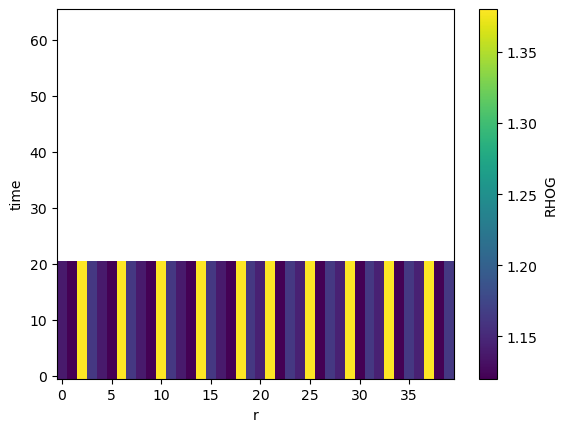

In [189]:
ds2.RHOG.isel(i=0,j=0,k=0).plot()

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [29]:
X = ds2.GRD_x.isel(xyz=0)

In [44]:
ds2

<xarray.Dataset> Size: 105MB
Dimensions:  (i: 18, j: 18, r: 40, xyz: 3, time: 4, k: 42)
Coordinates:
    GRD_x    (i, j, r, xyz) float64 311kB ...
  * time     (time) int64 32B 0 1 2 3
Dimensions without coordinates: i, j, r, xyz, k
Data variables:
    RHOG     (time, i, j, k, r) float64 17MB ...
    RHOGE    (time, i, j, k, r) float64 17MB ...
    RHOGVX   (time, i, j, k, r) float64 17MB ...
    RHOGVY   (time, i, j, k, r) float64 17MB ...
    RHOGVZ   (time, i, j, k, r) float64 17MB ...
    RHOGW    (time, i, j, k, r) float64 17MB ...
Attributes:
    config:   some\n            longer config\n            
    history:  derived from ...
    title:    fancy simulation

In [30]:
X

<xarray.DataArray 'GRD_x' (i: 18, j: 18, r: 40)> Size: 104kB
[12960 values with dtype=float64]
Coordinates:
    GRD_x    (i, j, r) float64 104kB ...
Dimensions without coordinates: i, j, r

In [33]:
Y = ds2.GRD_x.isel(xyz=1)

In [34]:
Z = ds2.GRD_x.isel(xyz=2)

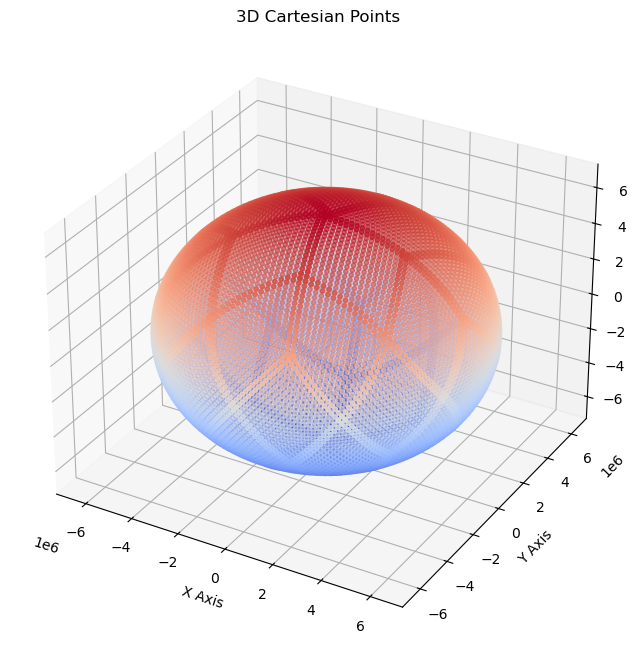

In [35]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Flatten X, Y, Z for plotting
ax.scatter(X.values.flatten(), Y.values.flatten(), Z.values.flatten(), c=Z.values.flatten(), cmap="coolwarm", s=10, alpha=0.6)

# Labels & Title
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("3D Cartesian Points")

plt.show()

In [31]:
X.values.flatten()

array([ 5.76824477e+06,  6.13167221e+06,  3.44303024e+06, ...,
       -1.03506743e+06, -1.78411623e-08, -1.76096190e+06], shape=(12960,))

In [36]:
X

<xarray.DataArray 'GRD_x' (i: 18, j: 18, r: 40)> Size: 104kB
array([[[ 5.768245e+06,  6.131672e+06, ...,  3.943471e+06,  1.888166e+06],
        [ 5.668095e+06,  6.092225e+06, ...,  3.847412e+06,  1.817099e+06],
        ...,
        [ 3.443030e+06,  4.514401e+06, ...,  1.932711e+06,  2.489977e+05],
        [ 3.250912e+06,  4.352802e+06, ...,  1.760962e+06,  1.185399e+05]],

       [[ 5.768245e+06,  6.094981e+06, ...,  3.838464e+06,  1.744667e+06],
        [ 5.698592e+06,  6.059390e+06, ...,  3.744909e+06,  1.674774e+06],
        ...,
        [ 3.539252e+06,  4.542432e+06, ...,  1.894457e+06,  1.302622e+05],
        [ 3.349549e+06,  4.384616e+06, ...,  1.760962e+06, -1.784116e-08]],

       ...,

       [[ 6.131672e+06,  4.697556e+06, ...,  1.888166e+06, -7.925743e+05],
        [ 6.092225e+06,  4.735810e+06, ...,  1.817099e+06, -8.519421e+05],
        ...,
        [ 4.514401e+06,  3.943471e+06, ...,  2.489977e+05, -1.570365e+06],
        [ 4.352802e+06,  3.847412e+06, ...,  1.185399e+05, -1.670515e+06]],

       [[ 6.094981e+06,  4.610258e+06, ...,  1.744667e+06, -9.751491e+05],
        [ 6.059390e+06,  4.610258e+06, ...,  1.674774e+06, -1.035067e+06],
        ...,
        [ 4.542432e+06,  3.838464e+06, ...,  1.302622e+05, -1.732411e+06],
        [ 4.384616e+06,  3.744909e+06, ..., -1.784116e-08, -1.760962e+06]]],
      shape=(18, 18, 40))
Coordinates:
    GRD_x    (i, j, r) float64 104kB ...
Dimensions without coordinates: i, j, r

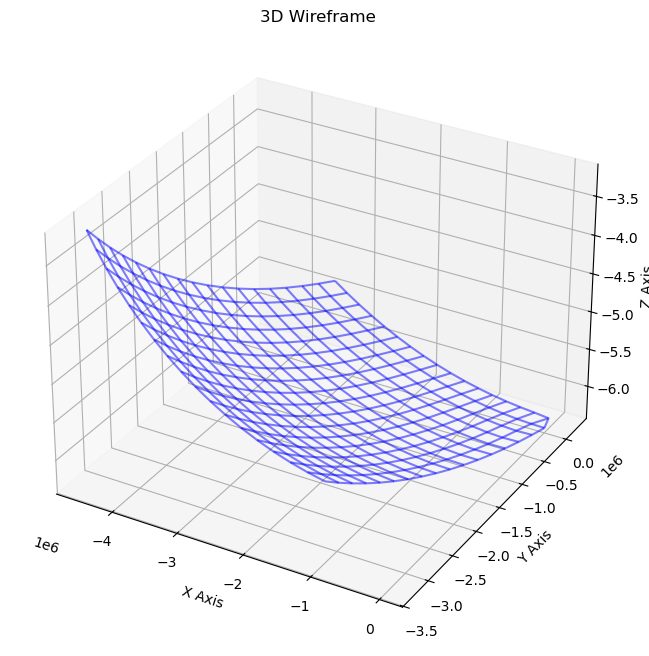

In [21]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot wireframe (for the first "40" slice)
ax.plot_wireframe(X[:,:,29], Y[:,:,29], Z[:,:,29], color='blue', alpha=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("3D Wireframe")
plt.show()

In [162]:
def join_halo(ds):
    return ds.isel(i=slice(1, -1), j=slice(1, -1)).stack(cell=("r", "i", "j"))

In [168]:
ds3 = ds2.pipe(join_halo)
ds3

<xarray.Dataset> Size: 1GB
Dimensions:  (xyz: 3, cell: 10240, time: 66, k: 42)
Coordinates:
    GRD_x    (xyz, cell) float64 246kB dask.array<chunksize=(3, 10240), meta=np.ndarray>
  * time     (time) int64 528B 0 1 2 3 4 5 6 7 8 ... 57 58 59 60 61 62 63 64 65
  * cell     (cell) object 82kB MultiIndex
  * r        (cell) int64 82kB 0 0 0 0 0 0 0 0 0 ... 39 39 39 39 39 39 39 39 39
  * i        (cell) int64 82kB 0 0 0 0 0 0 0 0 0 ... 15 15 15 15 15 15 15 15 15
  * j        (cell) int64 82kB 0 1 2 3 4 5 6 7 8 9 ... 6 7 8 9 10 11 12 13 14 15
Dimensions without coordinates: xyz, k
Data variables:
    RHOG     (time, k, cell) float64 227MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGE    (time, k, cell) float64 227MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGVX   (time, k, cell) float64 227MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGVY   (time, k, cell) float64 227MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGVZ   (time, k, cell) float64 227MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGW    (time, k, cell) float64 227MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
Attributes:
    config:   some\n            longer config\n            
    history:  derived from ...
    title:    fancy simulation

In [169]:
from scipy.spatial import KDTree
import cartopy.crs as ccrs
import cartopy.feature as cf

def kd_resample(var, tree, xlims, ylims, nx, ny, src_crs, method="nearest", nest=True):
    # NOTE: we want the center coordinate of each pixel, thus we have to
    # compute the linspace over half a pixel size less than the plot's limits
    dx = (xlims[1] - xlims[0]) / nx
    dy = (ylims[1] - ylims[0]) / ny
    xvals = np.linspace(xlims[0] + dx / 2, xlims[1] - dx / 2, nx)
    yvals = np.linspace(ylims[0] + dy / 2, ylims[1] - dy / 2, ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    print("computing points")
    latlon = ccrs.PlateCarree().transform_points(
        src_crs, xvals2, yvals2, np.zeros_like(xvals2)
    )
    valid = np.all(np.isfinite(latlon), axis=-1)
    points = latlon[valid].T
    lon = np.deg2rad(points[0])
    lat = np.deg2rad(points[1])
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    
    
    print("preparing output")
    res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)

    if method == "nearest":
        print("querying tree")
        dist, pix = tree.query(np.stack([x, y, z], axis=-1))
        print("getting data")
        res[valid] = var[pix]
    elif method == "linear":
        print("querying tree")
        dist, pix = tree.query(np.stack([x, y, z], axis=-1), k=6)
        w = 1 / dist
        total_w = np.sum(w, axis=-1)
        w = w / total_w[..., np.newaxis]
        print("getting data")
        res[valid] = np.sum(var.values[pix] * w, axis=-1)
    else:
        raise ValueError(f"interpolation method '{method}' not known")
    print("resampling done")
    return xr.DataArray(res, coords=[("y", yvals), ("x", xvals)])


def create_geoaxis(add_coastlines=True, **subplot_kw):
    """Convenience function to create a figure with a default map projection."""
    if "projection" not in subplot_kw:
        subplot_kw["projection"] = ccrs.Robinson(central_longitude=-135.58)

    _, ax = plt.subplots(subplot_kw=subplot_kw)
    ax.set_global()

    if add_coastlines:
        ax.coastlines(color="#333333", linewidth=plt.rcParams["grid.linewidth"])

    return ax


def get_current_geoaxis(**kwargs):
    """Return current axis, if it is a GeoAxes, otherwise create a new one."""
    # `plt.gcf().axes` only checks existing axes, while `plt.gca()` also creates one
    if (ax := plt.gcf().axes) and isinstance(ax[0], geoaxes.GeoAxes):
        return ax[0]
    else:
        return create_geoaxis(**kwargs)


def kd_show(
    var,
    tree,
    dpi=None,
    ax=None,
    method="nearest",
    nest=True,
    add_coastlines=True,
    antialias=False,
    **kwargs,
):
    if ax is None:
        ax = get_current_geoaxis(add_coastlines=add_coastlines)
    fig = ax.get_figure()

    if dpi is not None:
        fig.set_dpi(dpi)

    _, _, nx, ny = np.array(ax.bbox.bounds, dtype=int)

    if antialias:
        nx *= 2
        ny *= 2

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    im = kd_resample(var, tree, xlims, ylims, nx, ny, ax.projection, method, nest)

    return ax.imshow(im, extent=xlims + ylims, origin="lower", **kwargs)


def kd_contour(
    var, tree, dpi=None, ax=None, method="linear", nest=True, add_coastlines=True, **kwargs
):
    if ax is None:
        ax = get_current_geoaxis(add_coastlines=add_coastlines)
    fig = ax.get_figure()

    if dpi is not None:
        fig.set_dpi(dpi)

    _, _, nx, ny = np.array(ax.bbox.bounds, dtype=int)

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    im = kd_resample(var, tree, xlims, ylims, nx, ny, ax.projection, method, nest)

    return ax.contour(im.x, im.y, im, **kwargs)

In [170]:
def normalize(var):
    n = np.linalg.norm(var, axis=-1)
    return var / n[..., np.newaxis]
tree = KDTree(normalize(ds3.GRD_x.transpose("cell",  "xyz").values))

In [234]:
def worldmap(var, tree, **kwargs):
    projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=180)
    #projection = ccrs.NearsidePerspective()
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    sm = kd_show(var, tree, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    plt.colorbar(sm, ax=ax)
    return fig

computing points
preparing output
querying tree
getting data
resampling done


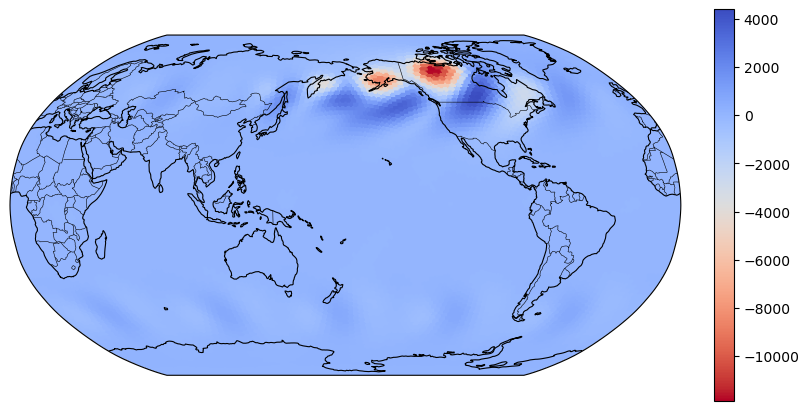

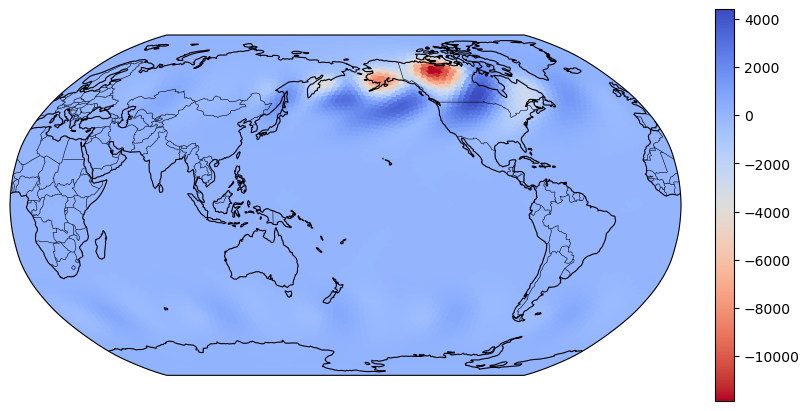

In [235]:
worldmap((ds3.RHOGE - ds3.RHOGE.isel(time=0)).isel(time=791//12, k=5), tree, cmap="coolwarm_r")

computing points
preparing output
querying tree
getting data
resampling done


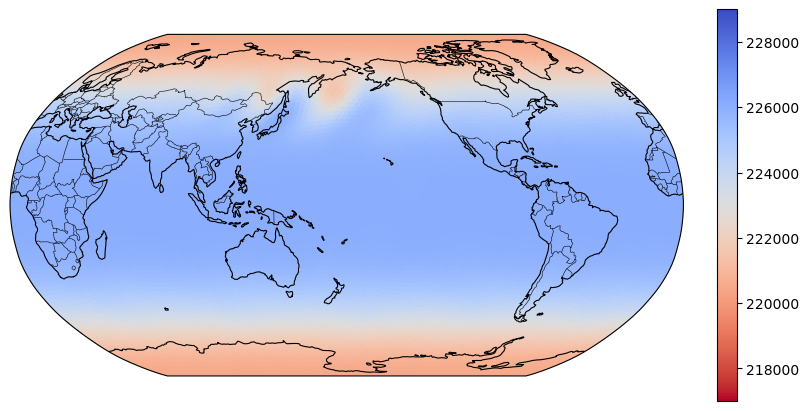

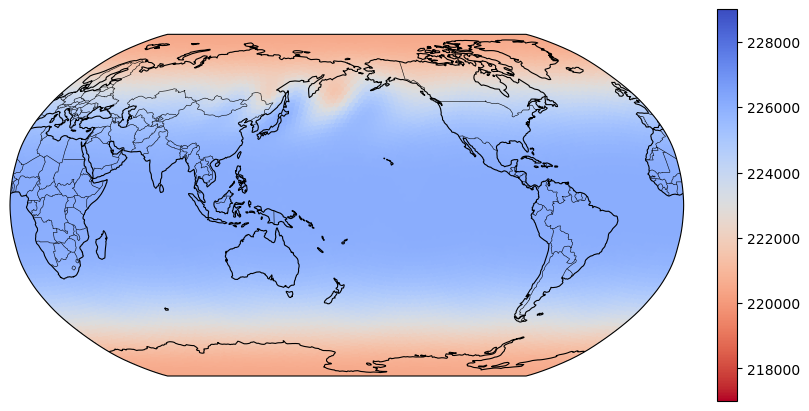

In [236]:
worldmap((ds3.RHOGE).isel(time=551//12, k=5), tree, cmap="coolwarm_r", vmin=217000, vmax=229000)

In [237]:
for i in range(ds3.sizes["time"]):
    fig = worldmap((ds3.RHOGE).isel(time=i, k=5), tree, cmap="coolwarm_r", vmin=217000, vmax=229000)
    plt.title(f"time = {i}")
    fig.savefig(f"rhoge_{i:05d}.png")
    plt.close("all")

computing points
preparing output
querying tree
getting data
resampling done
computing points
preparing output
querying tree
getting data
resampling done
computing points
preparing output
querying tree
getting data
resampling done
computing points
preparing output
querying tree
getting data
resampling done
computing points
preparing output
querying tree
getting data
resampling done
computing points
preparing output
querying tree
getting data
resampling done
computing points
preparing output
querying tree
getting data
resampling done
computing points
preparing output
querying tree
getting data
resampling done
computing points
preparing output
querying tree
getting data
resampling done
computing points
preparing output
querying tree
getting data
resampling done
computing points
preparing output
querying tree
getting data
resampling done
computing points
preparing output
querying tree
getting data
resampling done
computing points
preparing output
querying tree
getting data
resampling done

In [ ]:
NAME='nicam_gl11_sfcwind_cmap:cmo.ice-vmin:0-vmax:25' ffmpeg -framerate 30 -pattern_type glob -i "out/$NAME_*.png" -s:v 1000x1000 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p -y nicam_sfcwind.mp4

computing points
preparing output
querying tree
getting data
resampling done


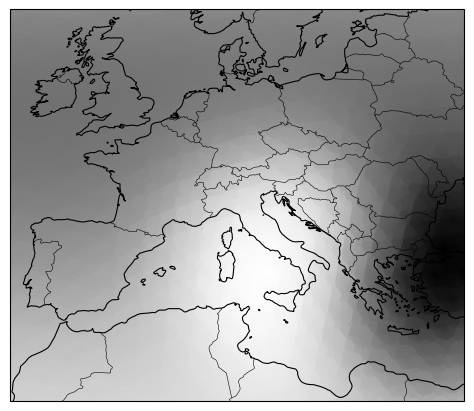

In [186]:
projection = ccrs.Robinson(central_longitude=10)
fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([-10, 30, 30, 60], crs=ccrs.PlateCarree())

kd_show(ds3.RHOGE.isel(time=0, k=3), tree, ax=ax, cmap="Greys", method="linear")
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)

In [187]:
ds3

<xarray.Dataset> Size: 1GB
Dimensions:  (xyz: 3, cell: 10240, time: 66, k: 42)
Coordinates:
    GRD_x    (xyz, cell) float64 246kB dask.array<chunksize=(3, 10240), meta=np.ndarray>
  * time     (time) int64 528B 0 1 2 3 4 5 6 7 8 ... 57 58 59 60 61 62 63 64 65
  * cell     (cell) object 82kB MultiIndex
  * r        (cell) int64 82kB 0 0 0 0 0 0 0 0 0 ... 39 39 39 39 39 39 39 39 39
  * i        (cell) int64 82kB 0 0 0 0 0 0 0 0 0 ... 15 15 15 15 15 15 15 15 15
  * j        (cell) int64 82kB 0 1 2 3 4 5 6 7 8 9 ... 6 7 8 9 10 11 12 13 14 15
Dimensions without coordinates: xyz, k
Data variables:
    RHOG     (time, k, cell) float64 227MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGE    (time, k, cell) float64 227MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGVX   (time, k, cell) float64 227MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGVY   (time, k, cell) float64 227MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGVZ   (time, k, cell) float64 227MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGW    (time, k, cell) float64 227MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
Attributes:
    config:   some\n            longer config\n            
    history:  derived from ...
    title:    fancy simulation

222573.92713379458 226055.8337847413
225510.19639805748 226059.23638317108
220513.95904868311 225717.0371913553
222429.6891360919 226058.48043106683
222584.19352671935 226075.41523805098
225494.41253859858 226102.27453012686
220513.95904868311 225719.78790958915
222454.00676704597 226094.32765957393
222607.63987509377 226057.62187208806
225502.5076428198 226058.4988968609
220513.95904868311 225710.8489049206
222433.93884865107 226058.4988968609
222584.13372797833 226057.61577263955
225495.48619130085 226058.32380915293
220513.95904868311 225707.28875523224
222425.7096535606 226057.89321554976
222571.75190281202 226107.64499542196
225493.56100199936 226107.47807702512
220513.95904868311 225703.67960366586
222421.3037217752 226063.65647539607
222590.1400999285 226064.71052295127
220514.6037205193 225727.17659163498
225524.84403919356 226063.85887770166
222439.57156885945 226060.55015454214
222590.22515606513 226057.03107538665
220514.6037205193 225709.75807756346
225500.61050032947 22608

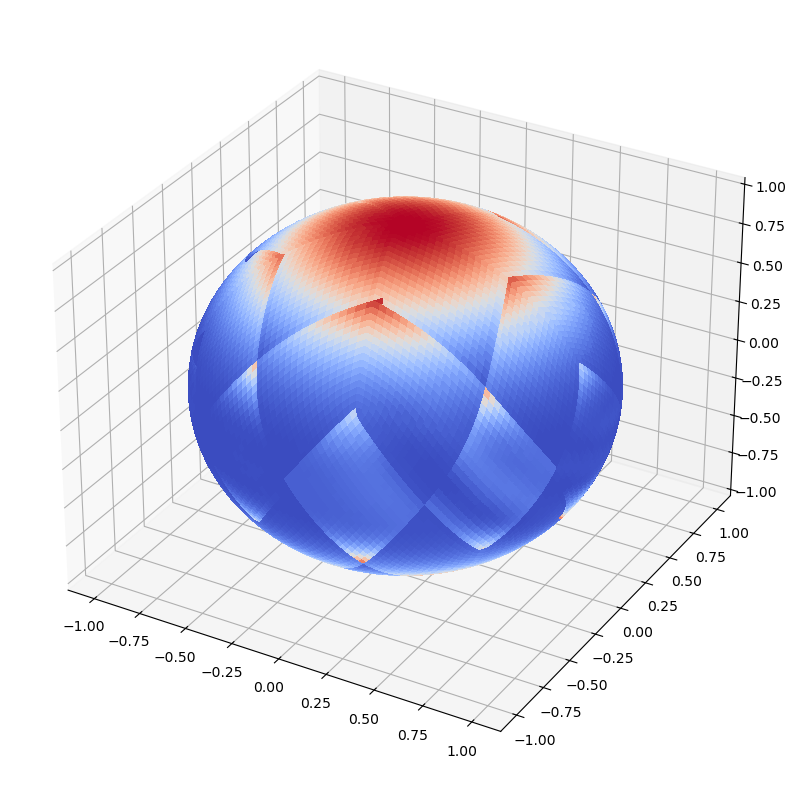

In [63]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')




for nr in range(0, 39):
    Xg = X.isel(r=nr)
    Yg = Y.isel(r=nr)
    Zg = Z.isel(r=nr)
# Xg = X.values.flatten()
# Yg = X.values.flatten()
# Zg = Z.values.flatten()
#Xg
#Yg
#Zg
    r = np.sqrt(Xg**2 + Yg**2 + Zg**2)
    Xg /= r
    Yg /= r
    Zg /= r
    
    field = ds2.RHOGE.isel(k=5,time=2,r=nr)
    norm_field = field
    #print(field.min().values, field.max().values)
    #vmin = field.min().values
    #vmax = field.max().values
    norm_field = (field - vmin) / (vmax - vmin)
    ax.plot_surface(
            Xg, Yg, Zg,
            #facecolors=plt.cm.viridis(norm_field),
            facecolors=plt.cm.coolwarm_r(norm_field),
            rstride=1, cstride=1,
            antialiased=False, shade=False
        )

In [57]:
ds2.RHOGE

<xarray.DataArray 'RHOGE' (time: 4, i: 18, j: 18, k: 42, r: 40)> Size: 17MB
[2177280 values with dtype=float64]
Coordinates:
  * time     (time) int64 32B 0 1 2 3
Dimensions without coordinates: i, j, k, r